<a href="https://colab.research.google.com/github/OnurKerimoglu/Colab_Notebooks/blob/master/Graph_networks_node_level_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Please, make a copy of the notebook before we start.
# Turn on the GPU support in the Runtime/Change runtime type.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Install Pytorch Geometric and its dependencies
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def visualize_both(h1, h2, title1, title2, color):
    z1 = TSNE(n_components=2).fit_transform(h1.detach().cpu().numpy())
    z2 = TSNE(n_components=2).fit_transform(h2.detach().cpu().numpy())

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].scatter(z1[:, 0], z1[:, 1], s=70, c=color, cmap="Set2")
    ax[0].set_title(title1)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].scatter(z2[:, 0], z2[:, 1], s=70, c=color, cmap="Set2")
    ax[1].set_title(title2)
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.show()

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 38.7 MB/s 
     |████████████████████████████████| 3.5 MB 28.1 MB/s 


# **Transductive & Inductive learning on graphs**

>"[Transductive inference](https://en.wikipedia.org/wiki/Transduction_(machine_learning)) is reasoning from observed, specific (training) cases to specific (test) cases." \
>Inductive inference "is reasoning from observed training cases to general rules, which are then applied to the test cases."

What does it actually mean?


<center width="100%" style="padding:10px"> <img src ="https://drive.google.com/uc?id=1IkDcHZ9x0mdBsiFiLjHlgoykThitQyMi" width="600px"></center>


Inductive inference  | Transductive inference
-------------------|------------------
Train the model and label unlabelled points which we **have never encountered**. | Train the model and label unlabelled points which we **have already encountered**.
**Use the initially trained model** for prediction of new unlabelled points. | **Retrain the model** to predict new unlabelled points.
Can predict **any point** in the feature space. | Can predict **only the points encountered in the test dataset**.
**Less** computational costs. | Can become **more** computationally costly.




#### **GCN layer revisited**

Let's have a look at the GCN layer one more time:
* $\hat A = A + I$ - sum of the adjacency matrix and an identity matrix. $\hat A \in R^{N \times N}$
* $\hat D$ - a diagonal node degree matrix of $\hat A$.

$$H^{l+1} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{l}W^{l}\right)$$

**The adjacency matrix is inside the formula of the update rule!**

**<font color='red'>The nature of the GCN layer is that it only* works in the transductive setting.</font>**

Consequences:

*   It's impossible to classify a newly added node without retraining the model, since the size of the adjacency matrix would change.
*   Even if we use the trained model with the graph of the same size the predictions would be meaningless, since the adjacency matrix would contain different entries.

**What do we need to do to be able to use a trained model with a completely different graph?**

*   Implement the GCN layer in a form that allows to use inductive learning**. (Check PyG implementations). 
*   Use differrent algorithms, e.g. [generalized message passing algorithm from DeepMind](https://arxiv.org/abs/1806.01261). We will do it in the next colab.


\* It depends on the implementation. PyG implementation allows it to work in the inductive setting out of the box. \
\** It's not guaranteed that the results on the unseen data would be any good because of the nature of graph convolutions that can be represented as polynomial functions of the adjacency matrix. Explanations: [Graph Representation Learing: Chapter 7](https://www.cs.mcgill.ca/~wlh/grl_book/)

# **PyTorch Geometric: Introduction via Node Classification**

*   Implementing GNNs with an adjacency matrix is simple and straightforward but can be computationally expensive for large graphs.
*   **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)** is an extension to PyTorch, and consists of various methods and utilities for optimized and easy implementation of GNNs.

#### **Dataset**
PyTorch Geometric provides an easy access to the dataset via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage.

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='data/Planetoid', name='Cora')
print(f'Dataset: {dataset}:')
print('=========================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Processing...
Done!



We will use `Cora` dataset, which is a **citation network** where nodes represent documents. Each node is described by a 1433-dimensional bag-of-words feature vector. Two documents are connected if there exists a citation link between them.

We can extract the first (and the only) graph, represented by PyG class [Data](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data), from the dataset object and gather some statistics about it.

In [3]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(2 * data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 7.80
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


The `train_mask`, `val_mask`, and `test_mask` are boolean masks that indicate which nodes we should use for training, validation, and testing

In [4]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

#### **Edge index**

*   We represent node connectivity via the `edge_index` tensor.
*   Printing its transposed version shows us the edges between nodes, e.g. $[0, 633]$ means that there's an edge between node $0$ and node $633$.
*   The edge is shown twice for an undirected graph, but the positions of its values are switched, e.g. $[633, 0]$.
*   If a graph is directed, then there is an edge only one edge corresponding to each edge direction, e.g. $[0, 633]$ **only**.

In [7]:
from IPython.display import Javascript  # Restrict height of output cell.

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))
edge_index = data.edge_index
print(edge_index.t()[:100])

<IPython.core.display.Javascript object>

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        [   1,    2],
        [   1,  652],
        [   1,  654],
        [   2,    1],
        [   2,  332],
        [   2, 1454],
        [   2, 1666],
        [   2, 1986],
        [   3, 2544],
        [   4, 1016],
        [   4, 1256],
        [   4, 1761],
        [   4, 2175],
        [   4, 2176],
        [   5, 1629],
        [   5, 1659],
        [   5, 2546],
        [   6,  373],
        [   6, 1042],
        [   6, 1416],
        [   6, 1602],
        [   7,  208],
        [   8,  269],
        [   8,  281],
        [   8, 1996],
        [   9,  723],
        [   9, 2614],
        [  10,  476],
        [  10, 2545],
        [  11, 1655],
        [  11, 1839],
        [  12, 1001],
        [  12, 1318],
        [  12, 2661],
        [  12, 2662],
        [  13, 1701],
        [  13, 1810],
        [  14,  158],
        [  14, 2034],
        [  14, 2075],
        [  14, 2077],
        [  14, 2668],
        [ 

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.

## **Node classification**

The task is to infer the category of each document (7 in total), having only a small fraction, 5%, of labeled nodes in the training set.

Let's create an MLP baseline that is applied to each node independently. This way we can verify whether adding the graph information to the model indeed improves the prediction or not. However, it might also be that the features per node are already expressive enough to clearly point towards a specific class. 
 



In [9]:
from torch.nn import Linear, Dropout, ReLU

class MLP(torch.nn.Module):
    def __init__(self, c_in, c_out, c_hidden):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(c_in, c_hidden)
        self.lin2 = Linear(c_hidden, c_out)
        self.dropout = Dropout(p=0.5, inplace=False)

    def forward(self, x):
        x = self.lin1(x) #output dim = c_hidden
        x = ReLU()(x)
        x = self.dropout(x) #input dim = c_hidden
        return self.lin2(x)

c_in = dataset.num_features
c_out = dataset.num_classes
model = MLP(c_in=c_in, c_out=c_out, c_hidden=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


We can visualize the 7-dimensional node embeddings that out untrained model produces, using the [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) package that projects a high-dimensional data onto a low-dimensional plane in such a way that similar points are put close to each other.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


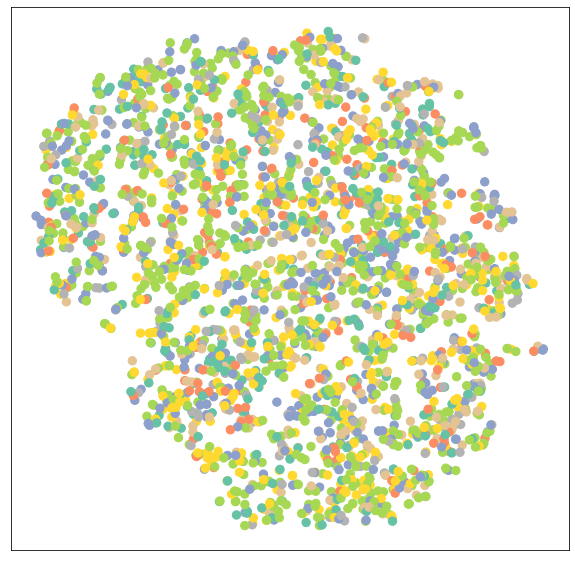

In [10]:
model.eval()

out = model(data.x)
visualize(out, color=data.y)

**As expected, the untrained model fails to separate the classes and produces similar embeddings for all 7 paper categories.**

Let's train the MLP model:

In [18]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

c_in = dataset.num_features
c_out = dataset.num_classes
mlp_model = MLP(c_in,
                c_out, 
                16) #c_hidden
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(),
                                     lr=0.01, 
                                     weight_decay=5e-4)

def train():
  mlp_model.train()
  optimizer.zero_grad()
  out = mlp_model(data.x)
  loss = loss_function(out[data.train_mask], data.y[data.train_mask])
  loss.backward() #compute grads
  optimizer.step() #apply grads
  return loss

def test(mask):
  mlp_model.eval()
  out = mlp_model(data.x)
  pred = out.argmax(dim=1)
  correct = pred[mask] == data.y[mask]
  acc = int(correct.sum()) /int(mask.sum())
  return acc

<IPython.core.display.Javascript object>

In [19]:
for epoch in range(1,201):
  train()
  train_acc = test(data.train_mask)
  val_acc = test(data.val_mask)
  test_acc = test(data.test_mask)

  print(
      f"Epoch: {epoch:03d}, Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}, Test acc: {test_acc:.4f}"
  )

Epoch: 001, Train acc: 0.2143, Val acc: 0.1060, Test acc: 0.1070
Epoch: 002, Train acc: 0.3429, Val acc: 0.1080, Test acc: 0.1110
Epoch: 003, Train acc: 0.6357, Val acc: 0.1480, Test acc: 0.1610
Epoch: 004, Train acc: 0.7714, Val acc: 0.2440, Test acc: 0.2360
Epoch: 005, Train acc: 0.8714, Val acc: 0.3380, Test acc: 0.3200
Epoch: 006, Train acc: 0.9214, Val acc: 0.4160, Test acc: 0.3910
Epoch: 007, Train acc: 0.9571, Val acc: 0.4500, Test acc: 0.4430
Epoch: 008, Train acc: 0.9714, Val acc: 0.4840, Test acc: 0.4600
Epoch: 009, Train acc: 0.9714, Val acc: 0.5120, Test acc: 0.4950
Epoch: 010, Train acc: 0.9714, Val acc: 0.5420, Test acc: 0.5120
Epoch: 011, Train acc: 0.9857, Val acc: 0.5500, Test acc: 0.5150
Epoch: 012, Train acc: 0.9857, Val acc: 0.5560, Test acc: 0.5220
Epoch: 013, Train acc: 0.9857, Val acc: 0.5600, Test acc: 0.5220
Epoch: 014, Train acc: 0.9857, Val acc: 0.5540, Test acc: 0.5250
Epoch: 015, Train acc: 0.9929, Val acc: 0.5580, Test acc: 0.5330
Epoch: 016, Train acc: 0.

**Reasons for poor MLP performance**

*   **Strong overfitting** due to only having access to a **small amount of training nodes**, that leads to poor generalization on the unseen nodes.
*   It also fails to incorporate an important inductive bias into the model: **Papers belonging to the same category are most likely to have a citation relation (edge) between them** $\to$ we can use a GNN to incorporate this information.

In [39]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, c_in, c_out, c_hidden):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(c_in, c_hidden)
        self.conv2 = GCNConv(c_hidden, c_out)
        self.dropout = Dropout(p=0.5, inplace=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) # Output dim = c_hidden
        x = ReLU()(x)
        x = self.dropout(x)
        return self.conv2(x, edge_index) # Input dim = c_hidden

In [40]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

c_in = dataset.num_features
c_out = dataset.num_classes
gcn_model = GCN(c_in=c_in, c_out=c_out, c_hidden=16)
print(gcn_model)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn_model.parameters(),
                                     lr=0.01, 
                                     weight_decay=5e-4)

def train():
  gcn_model.train()
  optimizer.zero_grad()
  out = gcn_model(data.x, data.edge_index)
  loss = loss_function(out[data.train_mask], data.y[data.train_mask])
  loss.backward() #compute grads
  optimizer.step() #apply grads
  return loss

def test(mask):
  gcn_model.eval()
  out = gcn_model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  correct = pred[mask] == data.y[mask]
  acc = int(correct.sum()) /int(mask.sum())
  return acc

<IPython.core.display.Javascript object>

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [41]:
for epoch in range(1,201):
  train()
  train_acc = test(data.train_mask)
  val_acc = test(data.val_mask)
  test_acc = test(data.test_mask)

  print(
      f"Epoch: {epoch:03d}, Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}, Test acc: {test_acc:.4f}"
  )

Epoch: 001, Train acc: 0.6643, Val acc: 0.4760, Test acc: 0.4860
Epoch: 002, Train acc: 0.8000, Val acc: 0.5520, Test acc: 0.5790
Epoch: 003, Train acc: 0.8357, Val acc: 0.5680, Test acc: 0.6100
Epoch: 004, Train acc: 0.9000, Val acc: 0.6080, Test acc: 0.6420
Epoch: 005, Train acc: 0.9071, Val acc: 0.6480, Test acc: 0.6760
Epoch: 006, Train acc: 0.9357, Val acc: 0.6860, Test acc: 0.7050
Epoch: 007, Train acc: 0.9500, Val acc: 0.7160, Test acc: 0.7290
Epoch: 008, Train acc: 0.9571, Val acc: 0.7280, Test acc: 0.7490
Epoch: 009, Train acc: 0.9571, Val acc: 0.7300, Test acc: 0.7590
Epoch: 010, Train acc: 0.9643, Val acc: 0.7480, Test acc: 0.7570
Epoch: 011, Train acc: 0.9786, Val acc: 0.7500, Test acc: 0.7660
Epoch: 012, Train acc: 0.9786, Val acc: 0.7600, Test acc: 0.7680
Epoch: 013, Train acc: 0.9857, Val acc: 0.7700, Test acc: 0.7780
Epoch: 014, Train acc: 0.9857, Val acc: 0.7760, Test acc: 0.7860
Epoch: 015, Train acc: 0.9857, Val acc: 0.7900, Test acc: 0.7890
Epoch: 016, Train acc: 0.

### **Exercise 2.1: MLP vs GCN untrained embeddings**

*   Create two new models, MLP and GCN, i.e. instances of the corresponding classes, using the same number of input/hidden/output channels. Please, use `c_hidden=256` for both models and name a new MLP model differently, so the trained model stays untouched, we will need it for later.
*   Following the example above, plot the lower dimensional representation of the node embeddings produced by the both models.
  - **hint:** don't forget to set the models to the evaluation mode. This will turn the dropout off.
  - **hint:** make use of the function `visualize_both` defined in the imports.
* Answer the following questions:
  - What is the difference between the embeddings?
  - Why do you think this difference exists?
  - What conclusions about GCNs can you draw?




/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


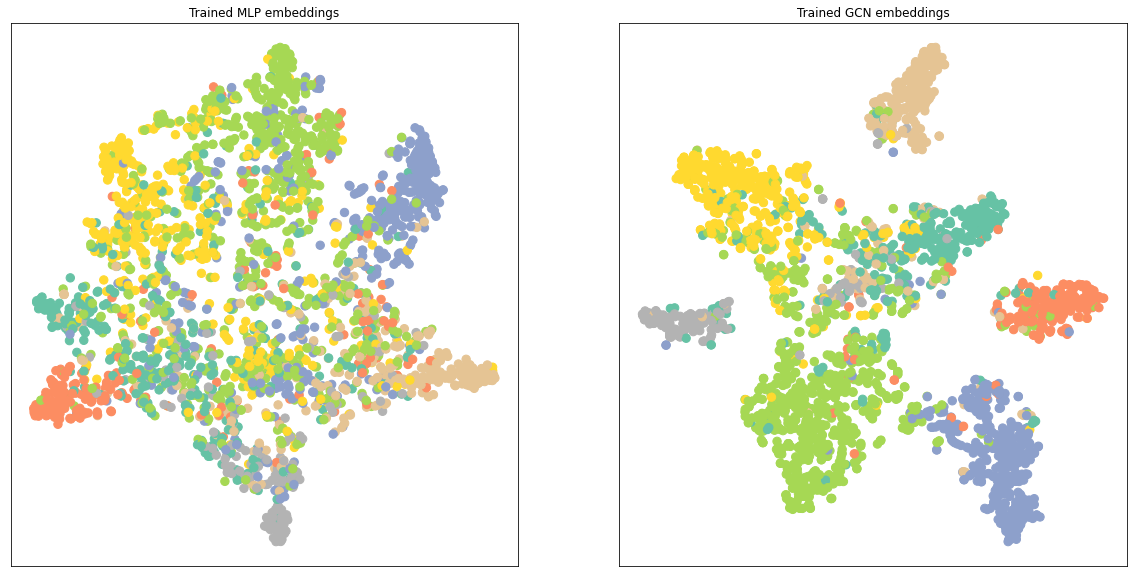

In [43]:
# Visualize the trained MLP vs GCN
c_in = dataset.num_features
c_out = dataset.num_classes

mlp_model.eval()
gcn_model.eval()

out_mlp = mlp_model(data.x)
mlp_title = 'Trained MLP embeddings'

out_gcn = gcn_model(data.x, data.edge_index)
gcn_title = 'Trained GCN embeddings'

visualize_both(out_mlp, out_gcn, mlp_title, gcn_title, color=data.y)  

#### **[The Weisfeiler-Lehman Isomorphism Test](https://davidbieber.com/post/2019-05-10-weisfeiler-lehman-isomorphism-test/)**

<center width="100%" style="padding:10px"> <img src ="https://drive.google.com/uc?id=1ar2xbg4lz0_-AjkT0Ic2EEHZKyXl2Mjl" width="600px"></center>

> "*Two graphs are considered isomorphic if there is a mapping between the nodes of the graphs that preserves node adjacencies.*"

**Algorithm:**

1.   Intialize all nodes features to 1.
2.   Get features $\{ h_{v_j} \}$ of neighboring nodes $\{ v_j \}$
3.   Update node feature $h_{v_i} \leftarrow \text{hash} (\sum_j h_{v_j})$ 
4.   Partition the nodes in the graph by their features. Repeat 2 + 3 for up to  (the number of nodes) iterations, or until there is no change in the partition of nodes by features from one iteration to the next.

If the partitions of two graphs are the same, then the graphs can be isomorphic.

*   Graph Convolutional layer-wise propagation rule in vector form:
$$h_{v_i}^{(l+1)} = \sigma (\sum_j \frac{1}{c_{ij}}  h_{v_j}^{(l)} W^{(l)}),$$
where $c_{ij}$ is a normalization constant for the edge.

*  The propagation rule can be interpreted as a differentiable and parametrized (with W(l)) variant of the hash function used in the Weisfeiler-Lehman algorithm.

**We get meaningful smooth embeddings where we can interpret distance as (dis-)similarity of local graph structures!**










### **Exercise 2.2: Train and visualize GCN**

*   Write code for training the GCN model.
  - **hint:** Modify the code for MLP training so that it runs with the GCN model.
  - **hint:** Use the same number of hidden channels.
*   Compare the results of the GCN and MLP.
*   Visualize trained embeddings of MLP and GCN.
  - **hint:** You can reuse the code from Exercise 2.1, you just need to use the trained models. Don't forget to set them to the eval mode.



In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# TODO: Write the training procedure below
# ... (~30 lines)


In [ ]:
# TODO: Visualize the embeddings of the trained MLP and GCN models
# ... (~7 lines)